**Bus 517 Machine Learning Methods Homework #4**  
Group 3 – John Cen, Gary Shao, Xuemeng Wu, Jiayan Zhang

# Assignment 4: Deep Learning


This assignment will give you practice using the library PyTorch, which is a popular library for constructing deep learning models. Deep Learning is a very powerful tool because it is able to learn very complicated functions. Deep Learning has revolutionized fields like image and speech recognition. 

The specific task we are trying to solve in this assignment is image classification. We will be using a very common dataset called CIFAR-10 that has 60,000 images separated into 10 classes. The classes are 
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In this assignment, you will practice:
* Reading documentation for a modern machine learning library
* Writing PyTorch code. 
* Evaluating neural network models.

**Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output.** Answers submitted that do not have associated code that shows the answer may not be accepted for credit. 

**Make sure to restart the kernel and run all cells** (especially before turning it in) to make sure your code runs correctly.

---
# Part 1 - Background Reading
Before starting this assignment, you should familiarize yourself with PyTorch. There are two options for this.
1) Work through the tutorial linked on Canvas with the assignment. It is interactive and uses Colab.
2)Work through [their tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and preferably follow along with a Colab notebook. You should only have to fully read the sections:
* What is PyTorch?
* Autograd: Automatic Differentiation
    * Just skim this section, it's a bit advanced but good to be aware of.
* Neural Networks
* Training a Classifier

You will probably also want to look at the [documentation](https://pytorch.org/docs/stable/index.html) to see what the specific values they are passing in during the tutorial.



# Assignment
**Before you start, make sure you have enabled GPU for your Colab Runtime.** In the Runtime drop down above, click on "Change runtime type" and select "GPU" in the Hardware Accelerator field.

First we import all of the modules we will use in this assignment.

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data
import torchvision.utils as utils
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Then we define some constants that will be used throughout the program.

In [0]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values. 
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS    = 20            # The number of times we loop over the whole dataset during training
BATCH_SIZE    = 100           # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The first step is to download the dataset using PyTorch. The code below produces a train set and a test set. Some notes on PyTorch terminology:
* Most of the time we use the `train_loader` instead of the `trainset`. The reason being the loader gives us batches of examples from the entire `trainset`. Looping over the `train_loader` returns a subset of the examples on each iteration.
* PyTorch commonly talks about "tensors". For our purposes, a tensor is just a multi-dimensional array. For example, the `trainset` is a tensor with shape `(50000, 32, 32, 3)` because there are 50,000 images, each is 32x32 pixels with 3 color channels (Red/Green/Blue). You can index into these just like `numpy` arrays.
* We pre-process the data into tensors and the normalize them so all the pixels have mean 0.5 and standard devaition 0.5.
* Training the models on the full dataset can take a long time. We have left some commented out code to help you sample the training/test data to speed up development time. We encourage you to un-comment the code line while you are figuring out how to write the code so it takes less time to run as long as you re-comment the lines out before training your final models.  

**IMPORTANT: Make sure you comment the sampling lines out and re-run your solution on the full dataset to get the correct results.** If you do not correctly train the models on the full dataset in your final submission, you will not get full credit.  

In [3]:
# We do a small amount of standardization on the image. 
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Uncomment the two lines below to speed up train time when debugging if your code works.
# It effectively takes a small chunk of the trianing and test set
# MAKE SURE TO RECOMMENT THE LINE OF CODE BEFORE SUBMITTING. Otherwise your results will be wrong.
# trainset, _ = torch.utils.data.random_split(trainset, [BATCH_SIZE * 10, len(trainset) - BATCH_SIZE * 10])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Uncomment line below to speed up train time when testing if your code works.
# MAKE SURE TO RECOMMENT THE LINE OF CODE BEFORE SUBMITTING. Otherwise your results will be wrong.
# testset, _ = torch.utils.data.random_split(testset, [BATCH_SIZE * 10, len(testset) - BATCH_SIZE * 10])
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(testset)

10000

In [5]:
train_loader

# Part 2: Visualizing the Data (5pts)
 In the following we will understand the dataset a bit better and visualize some of the images in CIFAR-10. In the following we extract a batch of images from the dataset and visualize them.

 **Question:** Explain the shape of ``images``. Which dimension corresponds to the number of images? Which to the color channels? And which to the shape of the image? 

> **Answer:** 100 corresponds to the number of images. 3 corresponds to the color channels and [32, 32] corresponds to the shape of the image

In [6]:
#@title
dataiter = iter(test_loader)
images_batch, labels_batch = dataiter.next()
print('size of images batch', images_batch.shape)
print('size of labels', labels_batch.shape)


size of images batch torch.Size([100, 3, 32, 32])
size of labels torch.Size([100])


Now we display a few of the images along with their labels. 

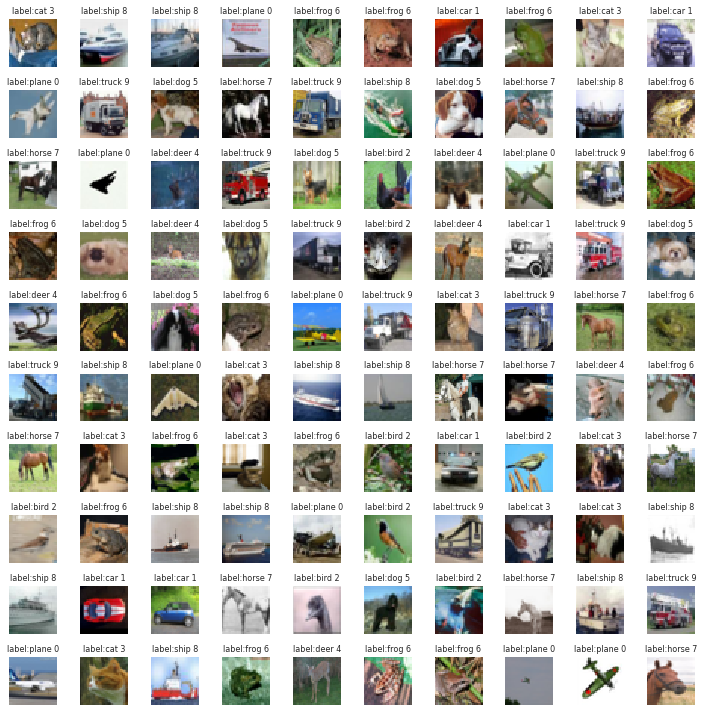

In [7]:
def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()[:100]
    fig, ax = plt.subplots(10,10, figsize=(10, 10))
    for i,img in enumerate(npimgs):
        ax[i//10, i%10].imshow(img.transpose(1,2,0), interpolation='nearest')
        ax[i//10, i%10].set_title('label:{} {}'.format(classes[labels[i]], labels[i]), fontsize=8)
        ax[i//10, i%10].set_axis_off()  
    fig.tight_layout(h_pad=1, w_pad=1)
    plt.show()
imshow(images_batch, labels_batch)


# Part 3 

----
In the cell below, we define the critical helper functions to train and visualize the results of the neural networks. 

You should read and understand what they are doing since the next step will ask you to modify one of them.
### Task 1 (5pts)
Right now the `train` function works, but we want to add extra functionality so that it keeps track of how the train/test accuracies change as training progresses (if the `compute_accs` parameter is true). It would be very inefficient to evaluate the train/test accuracy at the end of each batch, so instead we should only evaluate it at the end of each training epoch. 

Modify the code so that at the end of each epoch if `compute_accs` is true, it computes the training and test accuracies and puts those values at the end of  `train_accs` and `test_accs` respectively.


In [0]:
def train(net, train_loader, test_loader, 
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, 
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs. 
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of 
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer 
    # (algorithm like gradient descent). Here we use a common loss function for multi-class 
    # classification called the Cross Entropy Loss and the popular Adam algorithm for gradient descent.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()

    
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if (i + 1) % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        #TODO: use the accuracy function below to compute the train_acc and test_acc
        # and append them to train_accs and test_accs
        if compute_accs:
            train_acc = accuracy(net, train_loader)  #TODO
            test_acc = accuracy(net, test_loader) #TODO 
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')
    
    if compute_accs:
        return train_accs, test_accs
    else: 
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification 
    accuracy. 

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count
        
    return correct / total
    

def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained. 
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies 
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')
  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])


### Task 2 (20pts)
Now with all the helper code done, we are going to actually write the PyTorch code that specifies the neural network models. Each of the models described should be a different Python class with the specified name.

### `NetA`
The first neural network will be the simplest, in that it has no hidden layers. It should take the image and flatten it to a vector for the input, and then have 10 outputs, one for each class.

There should be no non-linearities for this network and is just a very simple linear classifier.


### `NetB`
The second neural network will be slightly more complicated in that it has a hidden layer with 300 nodes and adds a non-linearity between the layers. It should use the following operations in this order:
* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 300 hidden-neurons
* Use the ReLU activation function
* Use a fully-connected linear layer to the 10 outputs.

### `NetC`
This third neural network will be a convolutional neural network. It should use the following operations in this order: 
* Use a convolution layer with kernel-width 5 and depth 25
* Use the ReLU activation function
* Use a max-pool operation with kernel-width 2 and stride 2
* Flatten the image to a vector for the next step's input
* Use a fully-connected linear layer to the 10 outputs.

This architecture can be seen visually in the following diagram (the left-most object is the input image). 

![Network Architecture](https://courses.cs.washington.edu/courses/cse416/19su/files/assignment-resources/homework/hw7/nn.svg)

Notice that these diagrams use the notation 
```
channels @ height x width
``` 
to describe the dimensions of the results at each step. You may find the code from the Lecture 7 in class useful. 


In [0]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        #TODO
        self.linear = torch.nn.Linear(3*32*32,10)

    def forward(self, x):
        #TODO
        x = x.view(-1, 3*32*32)
        x = self.linear(x)
        return x


class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        #TODO
        self.linear1 = torch.nn.Linear(3*32*32,300)
        self.linear2 = torch.nn.Linear(300,10)

    def forward(self, x):
        #TODO
        x = x.view(-1, 3*32*32)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


class NetC(nn.Module):
    def __init__(self,):
        super(NetC, self).__init__()
        #TODO
        self.conv =nn.Conv2d(3,25,5)
        self.pool = nn.MaxPool2d((2,2))
        self.lin = nn.Linear(25*14*14, 10)

    def forward(self, x):
        #TODO
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1,25*14*14)
        x = self.lin(x)
        return x


Below is the cell that runs the main part of the code. It trains each of the 3 models you specified above for 10 epochs and then plots their train/test accuracies throughout the training process. When training all 3 models on the entire datasets, this should take about 15-20 minutes to run. 



**You are welcome (and encouraged) to change the `nets` list during development so you don't have to train all 3 models each time, but make sure your final result trains. For debugging purposes, you can uncomment the lines above where the a smaller portion of the training and test set are loaded.**

```
nets = [NetA(), NetB(), NetC()]
```

==== Training NetA ====
Epoch [1/20], Step [100/500], Loss: 1.8439
Epoch [1/20], Step [200/500], Loss: 1.7690
Epoch [1/20], Step [300/500], Loss: 1.9420
Epoch [1/20], Step [400/500], Loss: 1.8159
Epoch [1/20], Step [500/500], Loss: 1.8854
Epoch [1/20], Train Accuracy 40.62%, Test Accuracy 39.37%
Epoch [2/20], Step [100/500], Loss: 1.7871
Epoch [2/20], Step [200/500], Loss: 1.9054
Epoch [2/20], Step [300/500], Loss: 1.7370
Epoch [2/20], Step [400/500], Loss: 1.7902
Epoch [2/20], Step [500/500], Loss: 1.8140
Epoch [2/20], Train Accuracy 41.15%, Test Accuracy 38.60%
Epoch [3/20], Step [100/500], Loss: 1.5537
Epoch [3/20], Step [200/500], Loss: 1.6832
Epoch [3/20], Step [300/500], Loss: 1.8289
Epoch [3/20], Step [400/500], Loss: 1.8900
Epoch [3/20], Step [500/500], Loss: 1.7880
Epoch [3/20], Train Accuracy 40.47%, Test Accuracy 38.16%
Epoch [4/20], Step [100/500], Loss: 1.9317
Epoch [4/20], Step [200/500], Loss: 1.8716
Epoch [4/20], Step [300/500], Loss: 1.6314
Epoch [4/20], Step [400/500]

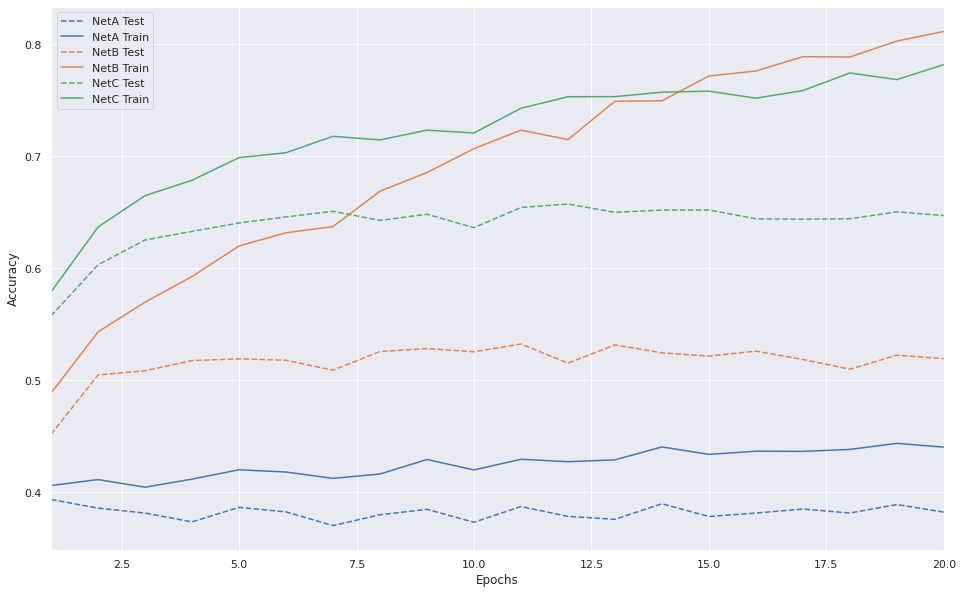

In [10]:
%%time 
nets = [NetA(), NetB(), NetC()]
histories = []

for net in nets:
    net_name = type(net).__name__
    print(f'==== Training {net_name} ====')
    train_history, test_history = train(net, train_loader, test_loader, 
                                        num_epochs=NUM_EPOCHS, 
                                        learning_rate=LEARNING_RATE, 
                                        compute_accs=True)
    histories.append({
        'name': net_name, 
        'train_accs': train_history, 
        'test_accs': test_history
    })
plot_history(histories)

**Question**: Which network had the highest Test accuracy after 20 epochs? 

> **Answer**: NetC network had the highest Test accuracy (64.71%) after 20 epochs.

# Part 4: Visualizing the outputs of layers (5 pts)

In this section we visualize the ouputs of the first convolutional layer of NetC above. Recall that convolutions capture local data.

**Question**: What is the output dimension after the first layer? Why?

> **Answer**: The dimension after the first layer is 28x28. Because we used the filter size of 5 in width, the dimension of the original image 32x32 reduced to 28x28

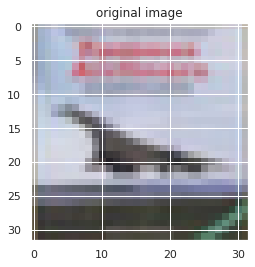

output of conv layer shape torch.Size([1, 25, 28, 28])


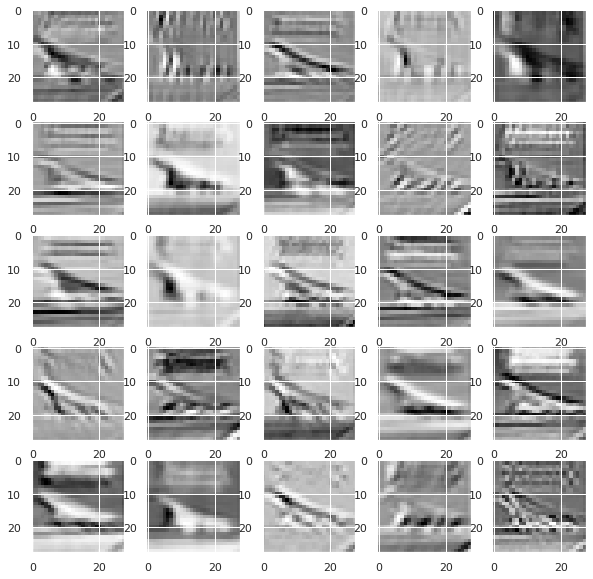

In [11]:
import numpy as np
dataiter = iter(test_loader)
images, labels = dataiter.next()
# change this to choose different images
image_idx = 3
inpt = images[image_idx][np.newaxis,...]

# un-normalize it
inpt = inpt/2+.5
plt.imshow(inpt[0].numpy().transpose(1,2,0), interpolation='nearest')
plt.title('original image')
plt.show()

# bring network C of the gpu to the cpu
nets[2].to('cpu')
# get the output of the first layer after passing the image in
output = nets[2].conv(inpt)
# Print its shape
print('output of conv layer shape', output.shape)
fig, ax = plt.subplots(5,5, figsize=(10,10))
for i in range(output.shape[1]):
    ax[i//5, i%5].imshow(output[0,i].detach().numpy(),interpolation='nearest', cmap=plt.get_cmap('Greys'))
plt.show()

# Part 5: Your Turn - `NetD` (20 pts)

Now it's your turn to design a neural network architecture! Your goal is to acheive 75% on the CIFAR10 test set that we loaded above. You can get their by
1. Changing hyperparameters such as batch size, the number of epochs, learning rate, optimizer, etc.
2. Adding additional convolutional and lienar layers.
3. Using different training methodologies such as using [Batch Normalization](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) and Drop out (I really recommend looking into these :) )

Create your own neural network architecture that has **at least 2 convolution layers** and **at least 2 fully connected layers**. 

For your convenience, I have reproduced some of the code we used above below so that you can train independently of the rest. I removed the comments to make it a bit shorter. If you want to change hyperparameters on training or the optimizer, I suggest making a copy of the ``train`` function below.

*Some notes*:
* Every convolution operation should be followed by a pooling operation. 
* Every linear layer and convolution layer should have an activation function. However, it is common to not have one on the very last layer to the 10 outputs so you do not need one there.
* Start with `NetC` and develop on top of it. 
* It is not required, but it might help to make your code more modular by adding parameters to the constructor to specify numbers that contain details about the architecture. Then you can automate trying many different settings of these hyper-parameters. If you do add these parameters, modify the cell later that produces the training plots to pass in the appropriate parameter values. 
* It's pretty tricky to get dimensions right in Torch. Use the `shape` command often to understand what the sizes are. For example, ``print(x.shape)``. The first dimension is generally the batch size, followed by the number of channels, and then the image size. You can use the ``.view`` command to resize the tensor.
* Finally, it's good practice to keep the number of output channels and the dimensions of inner layes in powers of 2 (i.e. 4, 16, 32, 64, ...). This speeds up training time on the GPU.
* One last piece of advice: don't be impatient. Sometimes you won't get the result you want unless you train for 50 epochs or so.
 

In practice, you would create a separate validation set and build a model on that. However in this exercise we will cheat a bit to keep the complexity down. The number of hyperparameters to tune in the last exercise combined with the slow training times will hopefully
give you a taste of how difficult it is to construct good performing networks. It should be emphasized that the
networks we constructed are tiny; typical networks have dozens of layers, each with hyperparameters to tune.

**Grading**: I will be running your code - to ensure it gets the necessary accuracy. Your grade on this will be in terms of a percentage relative to 75%. I.e. if your final accuracy is 60%, then you will earn 60/75*20 = 16

==== Training ====
Epoch [1/100], Step [100/500], Loss: 1.4684
Epoch [1/100], Step [200/500], Loss: 1.3053
Epoch [1/100], Step [300/500], Loss: 1.1094
Epoch [1/100], Step [400/500], Loss: 0.9447
Epoch [1/100], Step [500/500], Loss: 0.7580
Epoch [1/100], Train Accuracy 72.22%, Test Accuracy 68.86%
Epoch [2/100], Step [100/500], Loss: 0.7669
Epoch [2/100], Step [200/500], Loss: 0.9469
Epoch [2/100], Step [300/500], Loss: 0.7743
Epoch [2/100], Step [400/500], Loss: 0.6898
Epoch [2/100], Step [500/500], Loss: 0.7085
Epoch [2/100], Train Accuracy 79.43%, Test Accuracy 73.78%
Epoch [3/100], Step [100/500], Loss: 0.6198
Epoch [3/100], Step [200/500], Loss: 0.4563
Epoch [3/100], Step [300/500], Loss: 0.4218
Epoch [3/100], Step [400/500], Loss: 0.5478
Epoch [3/100], Step [500/500], Loss: 0.4197
Epoch [3/100], Train Accuracy 85.41%, Test Accuracy 77.73%
Epoch [4/100], Step [100/500], Loss: 0.6390
Epoch [4/100], Step [200/500], Loss: 0.4675
Epoch [4/100], Step [300/500], Loss: 0.4867
Epoch [4/100

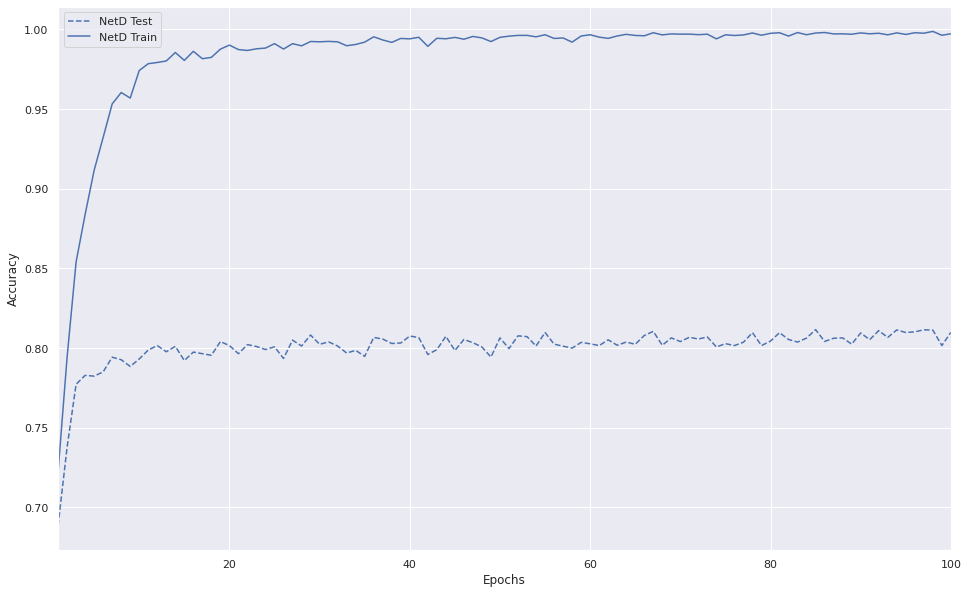

In [12]:
#%%time
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        #TODO
        self.conv = nn.Conv2d(3, 512, 3, padding=(1, 1))
        self.pool = nn.MaxPool2d((2,2))

        self.conv1 = nn.Conv2d(512, 256, 3, padding=(1, 1))
        self.pool1 = nn.MaxPool2d((2,2))

        self.conv2 = nn.Conv2d(256, 128, 3, padding=(1, 1))
        self.pool2 = nn.MaxPool2d((2,2))

        self.batchnorm2d0 = nn.BatchNorm2d(512)
        self.batchnorm2d1 = nn.BatchNorm2d(256)
        self.batchnorm2d2 = nn.BatchNorm2d(128)

        self.batchnorm1d0 = nn.BatchNorm1d(512)
        self.batchnorm1d1 = nn.BatchNorm1d(256)
        self.batchnorm1d2 = nn.BatchNorm1d(128)

        self.dropout = torch.nn.Dropout(0.10)     #10% probability

        self.lin = nn.Linear(128*4*4, 512) 
        self.lin1 = nn.Linear(512, 256)
        self.lin2 = nn.Linear(256, 128)
        self.lin3 = nn.Linear(128, 10)

    def forward(self, x):
        #TODO
        x = self.conv(x)
        x = self.batchnorm2d0(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv1(x)
        x = self.batchnorm2d1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchnorm2d2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 128*4*4)
        x = self.lin(x)
        x = self.batchnorm1d0(x)
        #x = self.dropout(x)
        x = F.relu(x)

        x = self.lin1(x)
        x = self.batchnorm1d1(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = self.batchnorm1d2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.lin3(x)
        return x

net = NetD()
histories = []

print(f'==== Training ====')
train_history, test_history = train(net, train_loader, test_loader, 
                                    num_epochs=100, 
                                    learning_rate=.001, 
                                    compute_accs=True)
histories.append({
        'name': 'NetD', 
        'train_accs': train_history, 
        'test_accs': test_history
})
plot_history(histories)